In [ ]:
# https://towardsdatascience.com/how-to-optimize-a-deep-learning-model-2e9ff8a4c5de

In [19]:
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import skopt
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize, forest_minimize
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args
print( "Tensorflow version: ", tf.__version__)

Tensorflow version:  2.5.0


In [20]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
# Load data
from sklearn.preprocessing import MinMaxScaler
from numpy import split
from numpy import array

df=pd.read_csv('5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
df=np.log(df+1)

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-28':'2021-05-30']

train = array(train)
test = array(test)

n_input = 14
n_out = 1

# convert history into inputs and outputs
train_x, train_y= split_sequences(train, n_input, n_out)
test_x, test_y= split_sequences(test, n_input, n_out)
train_x, validation_x, train_y, validation_y = train_test_split(train_x, train_y, test_size=0.2, random_state=2)


In [22]:
# Hyperparameter Initialization

dim_optimization = Categorical(categories=['adam', 'SGD'], name='optimization')
dim_learning_rate = Real(low=1e-3, high=1e-1, prior='log-uniform', name='learning_rate')
dim_num_layers = Integer(low=1, high=3, name='num_layers')
dim_num_dense_nodes = Integer(low=30, high=70, name='num_dense_nodes')
dim_dropout_prob = Real(low=0.01, high=0.5, prior='uniform', name='dropout_prob')
dim_activation = Categorical(categories=['sigmoid', 'softmax', 'relu'],name='activation')
dimensions = [dim_optimization, dim_learning_rate, dim_num_layers, dim_num_dense_nodes, dim_dropout_prob, dim_activation]

NUM_LAYERS = 2
BATCH_SIZE = 128
LEARNING_RATE = 0.001
DENSE_UNITS = 50
DROPOUT_PROB = 0.1
ACTIVATION_FUNC = 'relu'
LOSS_FUNC = 'mse'
METRIC = 'mape'
OTIMIZATION_FUNC = 'adam'
ACQ_FUNC = 'EI' # Expected Improvement
best_score = 10000
EPOCHS = 2000
N_CALLS = 200
default_parameters = [OTIMIZATION_FUNC, LEARNING_RATE, NUM_LAYERS, DENSE_UNITS, DROPOUT_PROB, ACTIVATION_FUNC]

In [23]:
# Multi-Headed MLP Model Generation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

def create_model(optimization, learning_rate, num_layers, num_dense_nodes, dropout_prob, activation):
    # first input model
    Layers = [0]*num_layers
    Drops=[0]*num_layers
    visible= [Input(shape=(n_input,)) for i in range(train_x.shape[2])]
    Layers[0]=[Dense(num_dense_nodes, activation=activation)(visible[i]) for i in range(train_x.shape[2])]
    Drops[0]=[Dropout(dropout_prob)(Layers[0][i]) for i in range(train_x.shape[2])]
    
    for n in range(num_layers-1):
        Layers[n+1]=[Dense(num_dense_nodes, activation=activation)(Layers[n][i]) for i in range(train_x.shape[2])]
        Drops[n+1]=[Dropout(dropout_prob)(Layers[n+1][i]) for i in range(train_x.shape[2])]
    merge = concatenate([Drops[num_layers-1][i] for i in range(train_x.shape[2])])
    output = Dense(n_out)(merge)
    model = Model(inputs=[visible[i] for i in range(train_x.shape[2])], outputs=output)
    
    
    if optimization == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    if optimization == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss=LOSS_FUNC, metrics=[METRIC])
    return model

In [24]:
# Function to Fit

@use_named_args(dimensions=dimensions)
def fitness(optimization, learning_rate, num_layers, num_dense_nodes, dropout_prob, activation):
    # Create the neural network
    model = create_model( optimization=optimization,
        learning_rate=learning_rate,num_layers=num_layers,
        num_dense_nodes=num_dense_nodes, dropout_prob=dropout_prob,
        activation=activation)
    
    # Save log for tensorboard
    callback_log = TensorBoard(
        log_dir =
"./21_logs/opt_{0}_lr_{1:.0e}_layers_{3}_nodes_{4}_dropout_{5}_activation_{5}/".format(
        optimization, learning_rate, num_layers, num_dense_nodes, dropout_prob, activation),
        histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
    
    # Train the model.
    train_xl=[train_x[:, :, i] for i in range(train_x.shape[2])]
    validation_xl=[validation_x[:, :, i] for i in range(train_x.shape[2])]
    
    history = model.fit( x= train_xl ,y= train_y, epochs=EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(validation_xl, validation_y), callbacks=[callback_log],verbose=0)
    
    # Get the final model performance.
    col = [x for x in list(history.history.keys()) if 'val_'+ METRIC in x]
    score = history.history[col[0]][-1]
    print("--> Validation {0}: {1:.3}".format(METRIC, score))
    global best_score
    # Track scores and save best model
    if score < best_score:
        model.save('Optimal-NN')
    best_score = score
    if score >= 1000 or np.isnan(score):
        score=1000
    # Clear model to save space
    del model
    K.clear_session()
    
    return score

In [25]:
# Gaussian Process Minimization

start = time.time()

search_result = gp_minimize(func=fitness,
    dimensions=dimensions,
    n_calls=N_CALLS,
    x0=default_parameters)

end = time.time()
print(f"Runtime of the program is {end - start}")


--> Validation mape: 9.74
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 95.9
--> Validation mape: 8.98
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 1.08e+02
--> Validation mape: 13.7
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 1.08e+02
--> Validation mape: 15.5
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 67.7
--> Validation mape: 8.23
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 1.09e+02
--> Validation mape: 37.1
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 13.5
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 7.62
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 8.87
--> Validation mape: 8.45
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 8.22
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 89.6
--> Validation m

c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.15
--> Validation mape: 23.3
--> Validation mape: 6.86
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 43.3
--> Validation mape: 8.0
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 8.6
--> Validation mape: 13.3
--> Validation mape: 6.78
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 7.83
--> Validation mape: 8.14
--> Validation mape: 20.4
--> Validation mape: 9.16
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 8.88
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 11.5
--> Validation mape: 7.4
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.44


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.79


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.11


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.27


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.75
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.01


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.73


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.83
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.93


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.21
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.81
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.55
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.55


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.8
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.6


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.89
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 9.98


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.22
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.68
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.98


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.93
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.51
--> Validation mape: 9.16
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.88
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.85
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.6
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.65


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.79
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.1


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.01
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 8.64


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.18
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.82
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.68


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.79
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.53


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.7
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.46
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 9.64


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.51
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 7.8
INFO:tensorflow:Assets written to: Optimal-NN\assets


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.08


c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--> Validation mape: 8.64
--> Validation mape: 10.6
--> Validation mape: 7.54
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 15.7
--> Validation mape: 8.31
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 8.01
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 7.96
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 7.77
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 7.84
--> Validation mape: 8.07
--> Validation mape: 7.2
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 7.71
--> Validation mape: 7.91
--> Validation mape: 6.97
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 8.49
--> Validation mape: 7.92
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 7.92
--> Validation mape: 7.59
INFO:tensorflow:Assets written to: Optimal-NN\assets
--> Validation mape: 8.8
--> Validation mape: 8.02
INFO:

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

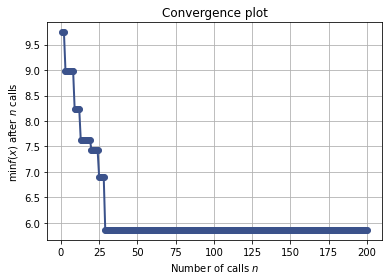

In [26]:
plot_convergence(search_result)

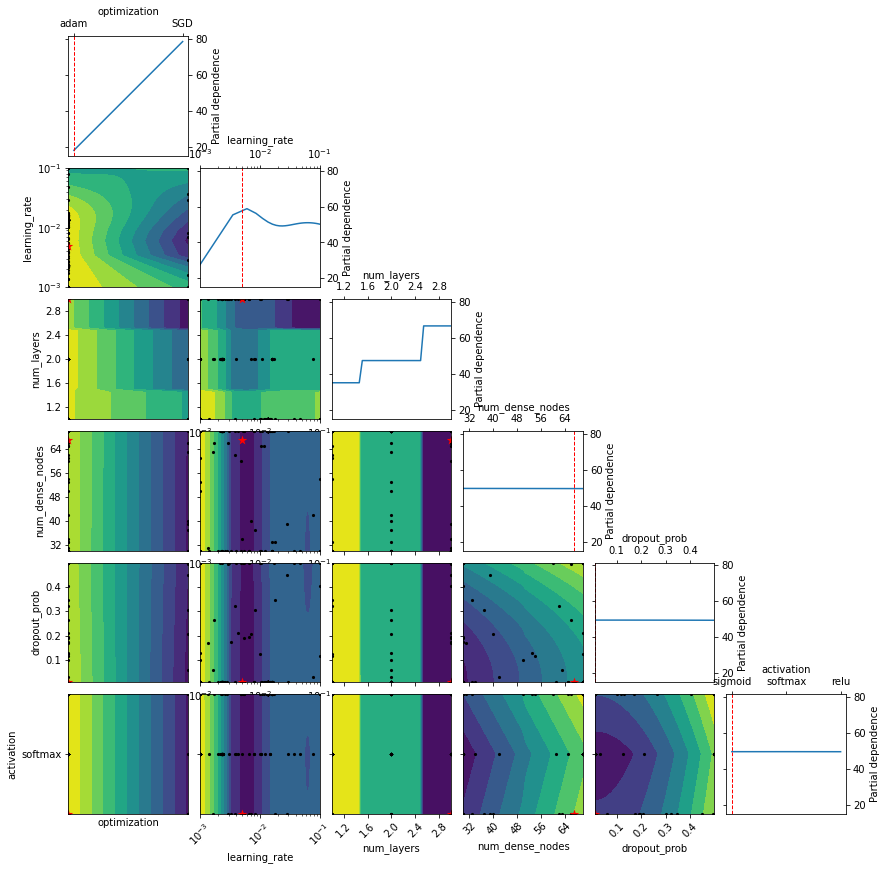

In [27]:
_ = plot_objective(result=search_result)

In [28]:
#https://scikit-optimize.github.io/stable/auto_examples/store-and-load-results.html
from skopt import dump, load
dump(search_result, 'mhMLP2.pkl')

In [12]:
#from skopt import dump, load
res_loaded = skopt.load('mhMLP.pkl')

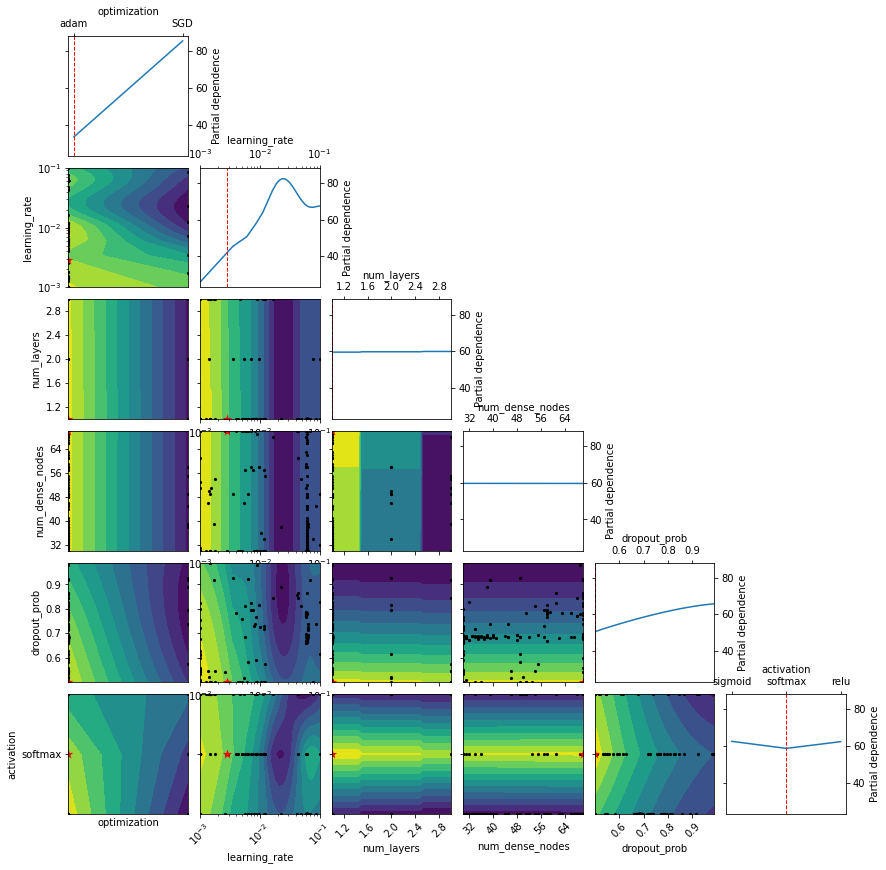

In [13]:
_ = plot_objective(result=res_loaded)

In [29]:
search_result.x

['adam', 0.0049329927947822285, 3, 67, 0.01, 'sigmoid']

In [30]:
search_result.fun

5.863099098205566

In [17]:
res_loaded.x_iters

[['adam', 0.001, 1, 30, 0.8, 'relu'],
 ['adam', 0.005437875211769186, 2, 46, 0.5172581764962749, 'relu'],
 ['SGD', 0.022990934275754285, 1, 38, 0.8888599826609817, 'sigmoid'],
 ['adam', 0.009804387333194832, 2, 58, 0.8145998153330066, 'sigmoid'],
 ['SGD', 0.0072355043083400395, 2, 58, 0.7945841692985762, 'sigmoid'],
 ['adam', 0.07692614986411396, 2, 34, 0.5015956555879645, 'relu'],
 ['adam', 0.005664629880460368, 1, 57, 0.686911298009207, 'sigmoid'],
 ['adam', 0.001356380254112945, 3, 46, 0.544126487339355, 'relu'],
 ['SGD', 0.08571701400322773, 1, 45, 0.737305918601382, 'sigmoid'],
 ['SGD', 0.0035309346798334776, 2, 49, 0.927939060459047, 'relu'],
 ['SGD', 0.012311800330450715, 3, 55, 0.5724937906038388, 'softmax'],
 ['adam', 0.0014647638200498824, 3, 49, 0.5, 'relu'],
 ['adam', 0.0015535684351842998, 3, 51, 0.5, 'relu'],
 ['adam', 0.001800270793190273, 3, 54, 0.5448158362729423, 'relu'],
 ['adam', 0.009045261926862223, 3, 30, 0.5, 'relu'],
 ['adam', 0.004608474409189597, 3, 30, 0.5, 

In [18]:
res_loaded.func_vals

array([ 16.51390839,  13.79295444, 132.50572205,  13.64929581,
       105.31932068, 100.20307159,  15.21973038,  12.93774509,
       107.17475128,  41.84856796, 108.60398865,  12.87398243,
        12.58595562,  16.28083611,  14.6621685 ,  12.97801018,
        13.1871357 ,  44.78772354,   9.16043854,  52.67248154,
        10.43389511,  10.96970749,  11.20212269,  12.16391373,
        15.51639843,   8.68961048,  80.02857208,  12.12790012,
        14.95077133,  10.78381252,  24.9074955 ,  20.55939865,
        12.90383053,  43.68048859,  42.02347183,   9.9668169 ,
         9.61929321,  11.16843987,  12.29481792,  10.07177639,
        10.8763361 ,  11.63202667,  24.6278038 ,  10.59932899,
        16.40497971,  11.77383041,  10.40911007,  14.1547184 ,
         8.19606876,   9.7091856 ,   9.51298809,  31.87203789,
         9.69484425,  12.15723705,   9.67631912,  12.81217861,
        11.83055782,  11.77084732,  11.451581  ,  13.9274292 ,
         9.88098907,   9.76308346,  13.0141964 ,  10.16